### import numpy as np

import matplotlib.pylab as plt

%matplotlib inline

from fof import fof

In [1]:
%load_ext Cython

In [2]:
%load_ext line_profiler
import line_profiler
import numpy as np
#Set compiler directives (cf. http://docs.cython.org/src/reference/compilation.html)
from Cython.Compiler.Options import directive_defaults

directive_defaults['linetrace'] = True
directive_defaults['binding'] = True

In [3]:
import spark_fof_c

In [4]:
import spark_fof

In [5]:
# create the arrays
pdt = np.dtype([('pos','f4', 3), ('iOrder', 'i4'), ('iGroup', 'i8')], align=True)
nps = 100000
ngs = 5
particles = np.zeros(nps, dtype=pdt)
done_ps = 0
centers = np.random.rand(ngs,3)*2 - 1
for group, center in zip(range(ngs), centers): 
    group_ps = nps/ngs
    if nps - (done_ps + group_ps) < group_ps:
        group_ps = nps - done_ps 
    particles['pos'][done_ps:done_ps+group_ps] = \
        np.random.multivariate_normal(center, [[.001,0,0],[0,.001,0],[0,0,.001]], group_ps)
    done_ps += group_ps
   
particles['iOrder'] = range(nps)

In [6]:
N = 1
tau = .05
mins = np.array([-1,-1,-1], dtype=np.float32)
maxs= np.array([1,1,1], dtype=np.float32)
domain_containers = spark_fof.setup_domain(N,tau,maxs,mins)

In [7]:
%%cython -I ./fof -a --compile-args=-DCYTHON_TRACE=1
from libc.math cimport floor

import numpy as np
cimport numpy as np

cimport cython

from fof cimport cfof

cdef struct Particle:
    float pos[3]
    np.int32_t iOrder
    np.int64_t iGroup

import spark_fof_c
from bisect import bisect_left

pdt = np.dtype([('pos','f4', 3), ('iOrder', 'i4'), ('iGroup', 'i8')], align=True)
        
@cython.boundscheck(False)
cdef bint in_rectangle_cython(float[:] mins, float[:] maxs, float[:] point) nogil:
    cdef float size
    cdef bint res=1
    cdef unsigned int i, ndim=3

    for i in range(ndim): 
        res *= (mins[i] < point[i] < maxs[i])
    return res

cdef inline bint rect_buffer_zone_cython(float[:] point, 
                                         float[:] mins, float[:] maxs, 
                                         float[:] mins_buff, float[:] maxs_buff) nogil:
    """Determine whether a particle is in the buffer zone"""
    cdef bint in_main, in_buffer

    in_main = in_rectangle_cython(mins, maxs, point)
    in_buffer = in_rectangle_cython(mins_buff, maxs_buff, point)
    return (in_main != in_buffer)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cpdef int get_bin_cython(float[:] point, int nbins, float[:] mins, float[:] maxs):
    cdef float dx, dy, dz, xbin, ybin, zbin
    cdef bint in_bounds = 1
    cdef int ndim = point.shape[0]
    # check bounds 
    for i in range(3): 
        in_bounds *= mins[i] <= point[i] <= maxs[i]
    if not in_bounds: 
        return -1
    
    dx = (maxs[0] - mins[0]) / <float>nbins
    dy = (maxs[1] - mins[1]) / <float>nbins
    dz = (maxs[2] - mins[2]) / <float>nbins
    xbin = floor((point[0] - mins[0]) / dx)
    ybin = floor((point[1] - mins[1]) / dy)
    zbin = floor((point[2] - mins[2]) / dz)
    return <int>(xbin + ybin * nbins + zbin*nbins*nbins)
    
@cython.boundscheck(False)
def new_partitioning_cython(Particle[:] p_arr, domain_containers, float tau, float[:] dom_mins, float[:] dom_maxs):
    cdef int N = domain_containers[0].N
    cdef unsigned int n_containers = len(domain_containers)
    cdef unsigned int nparts, i, j, k, ghost_ind=0, partition_ind
    cdef int my_bin, trans_bin, group
    cdef long left_ind, right_ind
    cdef float[:] point, t
    cdef float[:, :] trans = np.array([[-tau, 0, 0], 
                                       [0,-tau, 0], 
                                       [0, 0, -tau], 
                                       [-tau, -tau, 0], 
                                       [0, -tau, -tau], 
                                       [-tau,-tau,-tau]], 
                                      dtype=np.float32)
    cdef float[:] new_point = np.zeros(3, dtype=np.float32)
    cdef Particle[:] ghosts = np.zeros(<int>floor(p_arr.shape[0]*0.5), dtype=pdt)
    cdef Particle ghost_particle
    cdef int[:] trans_mark = np.zeros(6, dtype=np.int32)
    cdef float[:, :] mins = np.zeros((len(domain_containers),3), dtype=np.float32)
    cdef float[:, :] maxs = np.zeros((len(domain_containers),3), dtype=np.float32)
    cdef float[:, :] mins_buff = np.zeros((len(domain_containers),3), dtype=np.float32)
    cdef float[:, :] maxs_buff = np.zeros((len(domain_containers),3), dtype=np.float32)
    cdef float[:] min_temp 
    cdef float[:] max_temp 
    cdef float[:] min_buff_temp 
    cdef float[:] max_buff_temp 
    
    # set up domain limits
    for i in range(n_containers): 
        d = domain_containers[i]
        min_temp = d.mins.astype(np.float32)
        max_temp = d.maxes.astype(np.float32)
        min_buff_temp = d.bufferRectangle.mins.astype(np.float32)
        max_buff_temp = d.bufferRectangle.maxes.astype(np.float32)
        mins[i,:] = min_temp
        maxs[i] = max_temp
        mins_buff[i] = min_buff_temp
        maxs_buff[i] = max_buff_temp
    
    for i in range(p_arr.shape[0]):
        point = p_arr[i].pos
        my_bin = get_bin_cython(point, 2**N, dom_mins, dom_maxs)
        
        p_arr[i].iGroup = my_bin
        if rect_buffer_zone_cython(point, mins[my_bin], maxs[my_bin], mins_buff[my_bin], maxs_buff[my_bin]):
            ghost_particle = p_arr[i]
            trans_mark[:] = 0
            for j in range(6):
                t = trans[j]
                for k in range(3):
                    new_point[k] = point[k] + t[k]
                
                trans_bin = get_bin_cython(new_point, 2**N, dom_mins,dom_maxs)
       
                if trans_bin != my_bin and \
                   trans_bin >= 0 \
                   and not bin_already_there(trans_mark, trans_bin): 
                    
                    trans_mark[j] = trans_bin
                    ghost_particle.iGroup = trans_bin
                    ghosts[ghost_ind] = ghost_particle
                    ghost_ind+=1
                
    all_ps = np.concatenate([np.asarray(p_arr), np.asarray(ghosts)[np.nonzero(ghosts)[0]]])
    all_ps.sort(order='iGroup')
    partitions = np.unique(all_ps['iGroup'])

    left_ind = 0
    res = []
    for partition_ind in range(len(partitions)):
        if partition_ind == len(partitions)-1: 
            res.append((partitions[partition_ind], all_ps[left_ind:]))
        else : 
            right_ind = bisect_left(all_ps['iGroup'], partitions[partition_ind+1])
            res.append((partitions[partition_ind], all_ps[left_ind:right_ind]))
            left_ind=right_ind

@cython.boundscheck(False)
cdef inline bint bin_already_there(int[:] trans_mark, int bin) nogil: 
    cdef unsigned int ndim=6
    cdef unsigned int i
    
    for i in range(ndim): 
        if trans_mark[i] == bin: return 1
    return 0

In [10]:
def partition_wrapper(*args):
    return list(new_partitioning_cython(*args))

In [11]:
#Print profiling statistics using the `line_profiler` API
profile = line_profiler.LineProfiler(new_partitioning_cython)
profile.runcall(new_partitioning_cython, particles, domain_containers, tau, mins, maxs)
profile.print_stats()

Timer unit: 1e-06 s

Total time: 1.46186 s
File: /Users/rok/.ipython/cython/_cython_magic_dd358e243750b4ebbc9e5bf38338c65d.pyx
Function: new_partitioning_cython at line 63

Line #      Hits         Time  Per Hit   % Time  Line Contents
    63                                           def new_partitioning_cython(Particle[:] p_arr, domain_containers, float tau, float[:] dom_mins, float[:] dom_maxs):
    64         1            4      4.0      0.0      cdef int N = domain_containers[0].N
    65         1            1      1.0      0.0      cdef unsigned int n_containers = len(domain_containers)
    66         1            1      1.0      0.0      cdef unsigned int nparts, i, j, k, ghost_ind=0, partition_ind
    67                                               cdef int my_bin, trans_bin, group
    68                                               cdef long left_ind, right_ind
    69                                               cdef float[:] point, t
    70         3           30     10.0  

In [20]:
len(particles)

100000

In [21]:
%timeit new_partitioning_cython(particles, domain_containers, tau, mins, maxs)

1 loop, best of 3: 194 ms per loop


In [23]:
%timeit spark_fof_c.partition_particles_cython([particles], domain_containers, tau, mins.astype(np.double), maxs.astype(np.double))

The slowest run took 21.36 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.9 µs per loop


In [13]:
%%cython
import numpy as np
cimport numpy as np

cdef struct S1:
    float pos[3]
    int iGroup
    int iParti
    int iOrder

cdef struct S2:
    float pos[3]
    long iGroup
    int iOrder
    
 
def test_struct(S1[:] s1, S2[:] s2):
    return s1, s2

In [14]:
dt1 = np.dtype([('pos', 'f4', 3), ('iGroup', 'i4'), ('iParti', 'i4'), ('iOrder', 'i4')], align=True)
dt2 = np.dtype([('pos', 'f4', 3), ('iGroup', 'i8'), ('iOrder', 'i4')], align=True)

In [15]:
a = np.zeros(10, dtype=dt1)
b = np.zeros(10, dtype=dt2)

In [16]:
x, y = test_struct(a,b)

In [17]:
print x
print y

<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>


In [18]:
np.asarray(x)

array([([0.0, 0.0, 0.0], 0, 0, 0), ([0.0, 0.0, 0.0], 0, 0, 0),
       ([0.0, 0.0, 0.0], 0, 0, 0), ([0.0, 0.0, 0.0], 0, 0, 0),
       ([0.0, 0.0, 0.0], 0, 0, 0), ([0.0, 0.0, 0.0], 0, 0, 0),
       ([0.0, 0.0, 0.0], 0, 0, 0), ([0.0, 0.0, 0.0], 0, 0, 0),
       ([0.0, 0.0, 0.0], 0, 0, 0), ([0.0, 0.0, 0.0], 0, 0, 0)], 
      dtype=[('pos', '<f4', (3,)), ('iGroup', '<i4'), ('iParti', '<i4'), ('iOrder', '<i4')])

In [19]:
np.array(y)

/Users/rok/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Item size computed from the PEP 3118 buffer format string does not match the actual item size.
  if __name__ == '__main__':


TypeError: expected a readable buffer object

In [19]:
np.asarray(buffer(y))

TypeError: buffer object expected

In [243]:
%timeit list(spark_fof_c.partition_particles_cython([particles], domain_containers, 0.01, mins.astype(np.float), maxs.astype(np.float)))

1 loop, best of 3: 633 ms per loop


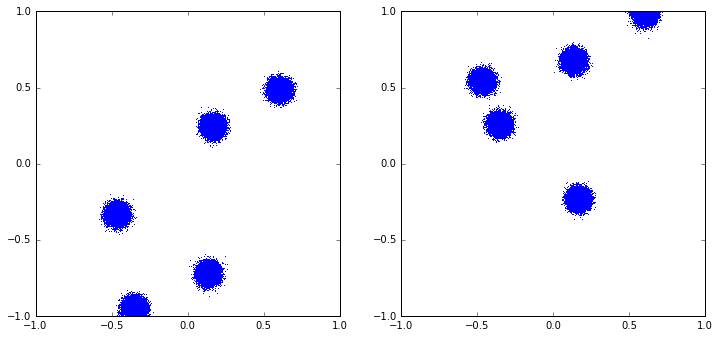

In [112]:
f, axs = plt.subplots(1,2, subplot_kw={'aspect':'equal'}, figsize=(12,12))
axs[0].plot(particles['pos'][:,0], particles['pos'][:,1], ',')
axs[1].plot(particles['pos'][:,0], particles['pos'][:,2], ',')
for ax in axs:
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)

In [5]:
%time fof.run(particles, 0.02)

CPU times: user 27.8 s, sys: 70.7 ms, total: 27.9 s
Wall time: 27.9 s


5

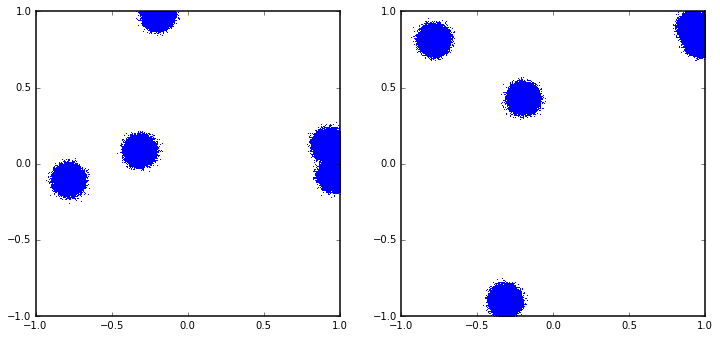

In [4]:
f, axs = plt.subplots(1,2, subplot_kw={'aspect':'equal'}, figsize=(12,12))
for group in range(ngs+1): 
    inds = np.where(particles['iGroup'] == group)[0]
    axs[0].plot(particles['pos'][inds,0], particles['pos'][inds,1], ',')
    axs[1].plot(particles['pos'][inds,0], particles['pos'][inds,2], ',')
for ax in axs:
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)

In [32]:
setup = """
import fof
import numpy as np
import spark_fof_c
mins=np.array([0.,0.,0.])
maxs=np.array([1.,1.,1.])
point=np.array([0.5,0.5,0.5])
mins_32 = mins.astype(np.float32)
maxs_32 = maxs.astype(np.float32)
point_32 = point.astype(np.float32)
"""

In [31]:
timeit.repeat("fof.call_check_within(mins_32, maxs_32, point_32)", setup=setup, repeat=10, number=100000)

[0.9535839557647705,
 0.8923609256744385,
 0.9031839370727539,
 0.8951680660247803,
 0.9193241596221924,
 0.898425817489624,
 0.9142448902130127,
 0.8969850540161133,
 0.8992099761962891,
 0.8953008651733398]

In [33]:
timeit.repeat("spark_fof_c.in_rectangle_cython(mins,maxs,point_32)", setup=setup, repeat=10, number=100000)

[0.34435105323791504,
 0.32041287422180176,
 0.312014102935791,
 0.33949804306030273,
 0.3078649044036865,
 0.358288049697876,
 0.3667490482330322,
 0.31624603271484375,
 0.3298821449279785,
 0.3383769989013672]

In [13]:
import spark_fof_c

In [35]:
%%timeit mins=np.array([0.,0.,0.]); maxs=np.array([1.,1.,1.]); \
point=np.array([0.5,0.5,0.5]); mins_32 = mins.astype(np.float32); \
maxs_32 = maxs.astype(np.float32); point_32 = point.astype(np.float32);

fof.call_check_within(mins_32, maxs_32, point_32)

100000 loops, best of 3: 13.9 µs per loop


In [34]:
%timeit spark_fof_c.in_rectangle_cython(mins,maxs,point_32)

The slowest run took 6.14 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.11 µs per loop
